In [1]:
pip install tifffile

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas
from tifffile import imread
from PIL import Image
from google.colab.patches import cv2_imshow
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from google.colab.patches import cv2_imshow

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = "cuda"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = "/content/drive/MyDrive/Sentinel/"
checkpoint_path = '/content/drive/MyDrive/Satellite_image_segmenattion/Checkpoints/unet_rgb_segmentation.pth.tar'
results_image_path = "/content/drive/MyDrive/Satellite_image_segmenattion/saved_image/"
images_path = data_path + "images"
labels_path = data_path + "labels"
images_id = [f.name for f in os.scandir(images_path)]

## **Visualization of a RGB Image along with its corresponding mask.**

In [6]:
def read_image(images_path,labels_path,id):
  image = os.path.join(images_path,images_id[id],"07.tif")
  label = os.path.join(labels_path,images_id[id],"dlt.tif")
  img = imread(image)
  label = imread(label)
  return img,label

def image_preprocessing(img):
  rgb_image = img[:,:,[2,1,0]]
  rgb_image = np.int16(rgb_image)
  rgb_image = np.clip(rgb_image,0,1500)
  rgb_image = rgb_image/1500 * 255
  rgb_image = np.float32(rgb_image)
  return rgb_image
  
def labelVisualize(num_class, color_dict, img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros((64, 64, 3))
    for i in range(num_class):
        img_out[img == i,:] = np.asarray(color_dict[i])
    return img_out

color_dict = {
    0: [255, 0, 0],
    1: [0, 255, 0],
    2: [0, 0, 255],
}


In [7]:
# visualization on 1 sample image
image,label = read_image(images_path,labels_path,id=20)
num_classes = len(np.unique(label))  # No of classes for segmentation
rgb_image = image_preprocessing(image)

# visualization on 2 sample image
image1,label1 = read_image(images_path,labels_path,id=5)
rgb_image_01 = image_preprocessing(image1)


Image


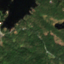

Label


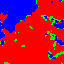

----------------------
Image


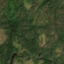

Label


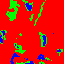

In [8]:
label = labelVisualize(num_classes,color_dict,label)
label_01 = labelVisualize(num_classes,color_dict,label1)
print("Image")
cv2_imshow(rgb_image)
print("Label")
cv2_imshow(label)
print("----------------------")
print("Image")
cv2_imshow(rgb_image_01)
print("Label")
cv2_imshow(label_01)

**Next shuffle and split the images in train(70%), val(20%), test(10%). I have stored the id's of the image in 3 seperate file.**


In [9]:
if os.path.exists('/content/drive/MyDrive/Sentinel/train.txt'):
  print("Train split file already exist")
else:
  random.shuffle(images_id)
  train_image_id = images_id[0:3960]
  with open("/content/drive/MyDrive/Sentinel/train.txt", "w") as f:
    for train_item in train_image_id:
        f.write("%s\n" % train_item)

if os.path.exists('/content/drive/MyDrive/Sentinel/val.txt'):
  print("Val split file already exist")
else:
  val_image_id = images_id[3960:5052]
  with open("/content/drive/MyDrive/Sentinel/val.txt", "w") as f:
      for val_item in val_image_id:
          f.write("%s\n" % val_item)

if os.path.exists('/content/drive/MyDrive/Sentinel/test.txt'):
  print("Test split file already exist")
else:
  test_image_id = images_id[5052:]
  with open("/content/drive/MyDrive/Sentinel/test.txt", "w") as f:
      for test_item in test_image_id:
          f.write("%s\n" % test_item)

with open("/content/drive/MyDrive/Sentinel/train.txt", "r") as f:
    train_idx = [idx.rstrip() for idx in f]
with open("/content/drive/MyDrive/Sentinel/val.txt", "r") as f:
    val_idx = [idx.rstrip() for idx in f]
with open("/content/drive/MyDrive/Sentinel/test.txt", "r") as f:
    test_idx = [idx.rstrip() for idx in f]


Train split file already exist
Val split file already exist
Test split file already exist


In [12]:
class Segmentation_Dataset(Dataset):
    """ Image Segmentation Dataset."""
    def __init__(self, data_path, images_ids):
        self.images_path = data_path + "images"
        self.labels_path = data_path + "labels"
        self.images_ids = images_ids

    def __len__(self):
        return len(self.images_ids)

    def __getitem__(self, idx):
        image = os.path.join(self.images_path,self.images_ids[idx],"07.tif")
        label = os.path.join(self.labels_path,self.images_ids[idx],"dlt.tif")
        image = imread(image)
        label = imread(label)
        label[label==255]=0
        # Data Preprocesing
        rgb_image = np.transpose(image[:,:,[2,1,0]])
        rgb_image = np.int16(rgb_image)
        rgb_image = np.clip(rgb_image,0,2000)
        rgb_image = rgb_image/2000 * 255
        rgb_image = np.float32(rgb_image)
        rgb_image = torch.tensor(rgb_image)
        label = torch.tensor(label)
        return rgb_image,label

In [13]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Conv block
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        # Upconv block
        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand


In [14]:
unet = UNET(3,num_classes).cuda()

In [15]:
train_dataset = Segmentation_Dataset(data_path, train_idx)
val_dataset = Segmentation_Dataset(data_path, val_idx)
test_dataset = Segmentation_Dataset(data_path, test_idx)

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)
loss_function = nn.CrossEntropyLoss()

In [16]:
def train(model, dataloader, epochs, optimizer, loss_fn, device = "cuda"):
  model.train()
  train_running_loss = 0.0
  for iter,(image,label) in enumerate(dataloader):
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()

    output = model(image)
    loss = loss_function(output,label.long())
    if iter%100 == 0:
      print("Train epochs: "+str(epochs)+" Iteration: "+str(iter)+" loss: "+str(loss.item()))

    train_running_loss += loss.item()
    loss.backward()
    optimizer.step()
  
  return train_running_loss/len(dataloader)

def val(model, dataloader, epochs, loss_fn, device = "cuda"):
  model.eval()
  val_running_loss = 0.0
  for iter,(image,label) in enumerate(dataloader):
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    loss = loss_function(output,label.long())
    if iter%100 == 0:
      print("Val epochs: "+str(epochs)+" Iteration: "+str(iter)+" loss: "+str(loss.item()))

    val_running_loss += loss.item()

  return val_running_loss/len(dataloader)



**Due to limited resources, I have trained the model for 10 epochs. For better results we need to train the network for more epochs.**

In [ ]:
num_of_epochs = 10
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
min_loss = np.inf
for epoch in tqdm(range(num_of_epochs)):
  train_loss = train(unet, train_dl, epoch, optimizer, loss_fn, device="cuda")
  val_loss = val(unet, val_dl, epoch, loss_function, device="cuda")
  # writer.add_scalar("Loss/train", train_loss, epoch)
  # writer.add_scalar("Loss/val", val_loss, epoch)
  
  if (val_loss < min_loss):
    min_loss = val_loss
    checkpoint = {
        "model" : unet.state_dict(),
        "Val Loss" : val_loss
    }
    torch.save(checkpoint,checkpoint_path)


  0%|          | 0/10 [00:00<?, ?it/s]

Train epochs: 0 Iteration: 0 loss: 1.0459609031677246
Train epochs: 0 Iteration: 100 loss: 0.6876450181007385
Train epochs: 0 Iteration: 200 loss: 0.7914502620697021
Val epochs: 0 Iteration: 0 loss: 0.60783451795578



 10%|█         | 1/10 [57:11<8:34:45, 3431.67s/it]

Train epochs: 1 Iteration: 0 loss: 0.7133890986442566
Train epochs: 1 Iteration: 100 loss: 0.61830073595047
Train epochs: 1 Iteration: 200 loss: 0.7939656972885132
Val epochs: 1 Iteration: 0 loss: 0.7108995914459229



 20%|██        | 2/10 [57:49<5:21:48, 2413.60s/it]

Train epochs: 2 Iteration: 0 loss: 0.7337631583213806
Train epochs: 2 Iteration: 100 loss: 0.7895337343215942
Train epochs: 2 Iteration: 200 loss: 0.7699487209320068
Val epochs: 2 Iteration: 0 loss: 0.6046173572540283



 30%|███       | 3/10 [58:19<3:18:08, 1698.40s/it]

Train epochs: 3 Iteration: 0 loss: 0.5321299433708191
Train epochs: 3 Iteration: 100 loss: 0.6676788330078125
Train epochs: 3 Iteration: 200 loss: 0.5189341306686401
Val epochs: 3 Iteration: 0 loss: 0.6118295192718506



 40%|████      | 4/10 [58:49<1:59:46, 1197.77s/it]

Train epochs: 4 Iteration: 0 loss: 1.0758188962936401
Train epochs: 4 Iteration: 100 loss: 0.5880817770957947
Train epochs: 4 Iteration: 200 loss: 0.7642186284065247
Val epochs: 4 Iteration: 0 loss: 0.4621434807777405



 50%|█████     | 5/10 [59:18<1:10:36, 847.36s/it] 

Train epochs: 5 Iteration: 0 loss: 0.5520367622375488
Train epochs: 5 Iteration: 100 loss: 0.6778591871261597
Train epochs: 5 Iteration: 200 loss: 0.7471805810928345
Val epochs: 5 Iteration: 0 loss: 0.8941441178321838



 60%|██████    | 6/10 [59:49<40:09, 602.26s/it]  

Train epochs: 6 Iteration: 0 loss: 0.6289632320404053
Train epochs: 6 Iteration: 100 loss: 0.9033392071723938
Train epochs: 6 Iteration: 200 loss: 0.6777454614639282
Val epochs: 6 Iteration: 0 loss: 0.7122228145599365



 70%|███████   | 7/10 [1:00:19<21:32, 430.77s/it]

Train epochs: 7 Iteration: 0 loss: 0.6236622333526611
Train epochs: 7 Iteration: 100 loss: 0.485411137342453
Train epochs: 7 Iteration: 200 loss: 0.7328296303749084
Val epochs: 7 Iteration: 0 loss: 0.732997715473175



 80%|████████  | 8/10 [1:00:49<10:21, 310.56s/it]

Train epochs: 8 Iteration: 0 loss: 0.568823516368866
Train epochs: 8 Iteration: 100 loss: 0.7055308222770691
Train epochs: 8 Iteration: 200 loss: 0.79799485206604
Val epochs: 8 Iteration: 0 loss: 0.6599639058113098



 90%|█████████ | 9/10 [1:01:19<03:46, 226.30s/it]

Train epochs: 9 Iteration: 0 loss: 0.5337472558021545
Train epochs: 9 Iteration: 100 loss: 0.5658998489379883
Train epochs: 9 Iteration: 200 loss: 0.5811692476272583
Val epochs: 9 Iteration: 0 loss: 0.5896685123443604



100%|██████████| 10/10 [1:01:49<00:00, 370.96s/it]


### **Inference on RGB Image**

In [19]:
# Load RGB model
def Load_model(model_dir):  
  checkpoint = torch.load(model_dir)
  model = unet
  model.load_state_dict(checkpoint['model'])
  model = model.to(device="cuda")
  model.eval()
  return model

In [20]:
def one_hot_encoding(label):
    labels = [0, 1, 2]
    semantics = []
    for colour in labels:
        equality = np.equal(label, colour)
        semantics.append(equality)
    semantics = np.stack(semantics, axis=-1)
    return semantics

def accuracy(outputs, labels):
    tp = torch.sum(torch.logical_and(labels, outputs))
    tn = torch.numel(outputs) - torch.sum(torch.logical_or(labels, outputs))
    acc = (tp + tn) / torch.numel(outputs)
    return acc

def iou_matrix(outputs, labels):
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou = (torch.sum(intersection) + SMOOTH) / (torch.sum(union)+ SMOOTH)
    return iou

Image


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


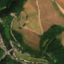

Label


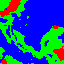

Network Output


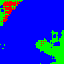

---------------------------
Image


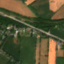

Label


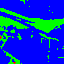

Network Output


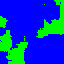

---------------------------
Image


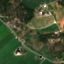

Label


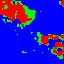

Network Output


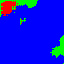

---------------------------
Image


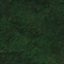

Label


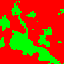

Network Output


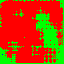

---------------------------
Image


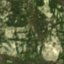

Label


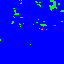

Network Output


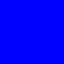

---------------------------
Image


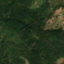

Label


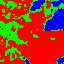

Network Output


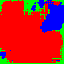

---------------------------
Image


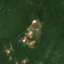

Label


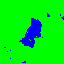

Network Output


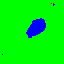

---------------------------
Image


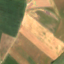

Label


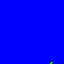

Network Output


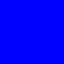

---------------------------
Mean Average Accutacy: tensor(0.8210) Mean IOU: tensor(0.5799)


<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [21]:
running_acc = 0.0
running_iou = 0.0
SMOOTH = 1e-6
# Load the model for inference
model = Load_model(checkpoint_path)
# iteration over all the test images
for idx, item in enumerate(test_dl):
  image = item[0].to(device)
  label = item[1]
  one_hot_label = one_hot_encoding(label.numpy())
  label = label.to(device)
  output = model(image)
  output = torch.argmax(output, dim=1)
  
  output_for_metrics = torch.Tensor(one_hot_encoding(output.detach().cpu().numpy())).int()
  label_for_metrics = torch.tensor(one_hot_label)

  # accuaracy metric
  acc = accuracy(output_for_metrics, label_for_metrics)
  running_acc += acc

  # iou metric
  iou = iou_matrix(output_for_metrics, label_for_metrics)
  running_iou += iou

  # Visualization of every 5th image from the test sample
  if idx % 5 == 0:
    fig = plt.figure(figsize=(10, 7))
    image = torch.transpose(image[0], 0, 2).cpu().numpy()

    output = output[0].detach().cpu().numpy()
    output = labelVisualize(3, color_dict, output)

    label = label[0].cpu().numpy()  
    label = labelVisualize(3, color_dict, label)

    cv2.imwrite(results_image_path+'res'+str(idx)+'_image.png',image)
    cv2.imwrite(results_image_path+'res'+str(idx)+'_label.png',label)
    cv2.imwrite(results_image_path+'res'+str(idx)+'_output.png',output)
    print("Image")
    cv2_imshow(image)
    print("Label")
    cv2_imshow(label)
    print("Network Output")
    cv2_imshow(output)
    print("---------------------------")
    if idx == 100:  # To visualize the results on the first few images from the test dataset
      break

mean_acc = running_acc / len(test_dl)  # Mean accuaracy
mean_iou = running_iou / len(test_dl)  # Mean IOU
print("Mean Average Accutacy: "+str(mean_acc)+" Mean IOU: "+str(mean_iou))